In [13]:
import pandas as pd
import requests
import json
import csv
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
pd.set_option('display.max_columns', None)

In [11]:
# API parameters
api_key = "04add5b7cdmshd4b470181d45798p1428bbjsn3f4be7e144f4"
api_host = "tripadvisor16.p.rapidapi.com"
url = "https://tripadvisor16.p.rapidapi.com/api/v1/flights/searchFlights"

# API customer inputs (this will come from UI when ready)
sourceAirportCode = "BOI"
destinationAirportCode = "ATL"
outDate = "2024-06-15"
itineraryType = "ROUND_TRIP"
sortOrder = "PRICE"
returnDate = "2024-06-30"
numAdults = "1"
numSeniors = "0"
classOfService = "ECONOMY"
pageNumber = "1" # for now fetch just first page to save on query number

# build API inputs
querystring = {"sourceAirportCode":sourceAirportCode,"destinationAirportCode":destinationAirportCode,\
               "date":outDate, "itineraryType":itineraryType,"sortOrder":sortOrder,\
               "numAdults":numAdults,"numSeniors":numSeniors,"returnDate": returnDate, \
               "classOfService":classOfService,"pageNumber":pageNumber, "currencyCode":"USD"}

headers = {"X-RapidAPI-Key": api_key,\
           "X-RapidAPI-Host": api_host}

In [12]:
# fetch data from API
response = requests.get(url, headers=headers, params=querystring)

In [13]:
# convert json to python dict
response_text = json.loads(response.text)

In [39]:
# # cell to visualize data structure for debug purpose
# response_text['data']['flights'][0]['segments'][1]['legs'][0]
# response_text['data']['flights'][2]['purchaseLinks'][0]

In [37]:
# unpack segments for each flight
# data structure:
# data
# |-----> flights: different itineraries
# |----------> segments: inbound/outbound
# |------------------> legs: different portions of same trip
segment_map = {0: 'outbound', 1: 'inbound'}
df_itin = pd.DataFrame(columns = ['itineraryID', 'itineraryCost', 'segmentID', 'legID', 'origin', 'destination',  \
                  'departureDateTime', 'arrivalDateTime'])

for j,itin in enumerate(response_text['data']['flights']):
    price = float(itin['purchaseLinks'][0]['totalPricePerPassenger']) # just index 0 reflects the cheapest option for that itinierary
    for i,segment in enumerate(itin['segments']):
        for k,leg in enumerate(segment['legs']):
            new_row = {'itineraryID': j, 'itineraryCost': price, 'segmentID': i, 'legID': k, 'origin': leg['originStationCode'],\
                'destination': leg['destinationStationCode'],  'departureDateTime': leg['departureDateTime'], \
                'arrivalDateTime': leg['arrivalDateTime']}
            df_itin = df_itin.append(new_row, ignore_index=True)
            
# map segmentID into outbound/inbound
df_itin['segmentType'] = df_itin['segmentID'].map(segment_map)
            
# convert to datetime
df_itin['departureDateTime']= pd.to_datetime(df_itin['departureDateTime'])
df_itin['arrivalDateTime']= pd.to_datetime(df_itin['arrivalDateTime'])

# flight duration column
df_itin['legDuration'] = (df_itin['arrivalDateTime']-df_itin['departureDateTime'])

# layover duration column
df_itin['nextFlightDeparture'] = df_itin.groupby(['itineraryID', 'segmentID'])['departureDateTime'].shift(-1)
df_itin['layoverDuration'] = (df_itin['nextFlightDeparture']-df_itin['arrivalDateTime'])

In [38]:
df_itin.head(100)

,itineraryID,itineraryCost,segmentID,legID,origin,destination,departureDateTime,arrivalDateTime,segmentType,legDuration,nextFlightDeparture,layoverDuration
0,0,597.20000,0,0,BOI,DEN,2024-06-15 07:00:00-06:00,2024-06-15 08:58:00-06:00,outbound,0 days 01:58:00,2024-06-15 23:59:00-06:00,0 days 15:01:00
1,0,597.20000,0,1,DEN,ATL,2024-06-15 23:59:00-06:00,2024-06-16 05:06:00-04:00,outbound,0 days 03:07:00,NaN,NaT
2,0,597.20000,1,0,ATL,DEN,2024-06-30 07:30:00-04:00,2024-06-30 08:51:00-06:00,inbound,0 days 03:21:00,2024-07-01 07:46:00-06:00,0 days 22:55:00
3,0,597.20000,1,1,DEN,BOI,2024-07-01 07:46:00-06:00,2024-07-01 09:41:00-06:00,inbound,0 days 01:55:00,NaN,NaT
4,1,620.20000,0,0,BOI,DEN,2024-06-15 14:15:00-06:00,2024-06-15 16:13:00-06:00,outbound,0 days 01:58:00,2024-06-15 17:55:00-06:00,0 days 01:42:00
5,1,620.20000,0,1,DEN,ATL,2024-06-15 17:55:00-06:00,2024-06-15 23:02:00-04:00,outbound,0 days 03:07:00,NaN,NaT
6,1,620.20000,1,0,ATL,SFO,2024-06-30 07:30:00-04:00,2024-06-30 09:46:00-07:00,inbound,0 days 05:16:00,2024-06-30 13:35:00-07:00,0 days 03:49:00
7,1,620.20000,1,1,SFO,BOI,2024-06-30 13:35:00-07:00,2024-06-30 16:13:00-06:00,inbound,0 days 01:38:00,NaN,NaT
8,2,631.81000,0,0,BOI,DEN,2024-06-15 17:35:00-06:00,2024-06-15 19:34:00-06:00,outbound,0 days 01:59:00,2024-06-15 23:59:00-06:00,0 days 04:25:00
9,2,631.81000,0,1,DEN,ATL,2024-06-15 23:59:00-06:00,2024-06-16 05:06:00-04:00,outbound,0 days 03:07:00,NaN,NaT


In [3]:
df = pd.read_csv(r'/Users/nicolaciocchini/Downloads/archive/flights_sample_3m.csv')

In [8]:
df.head()

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",1155,1151.0,-4.0,19.0,1210.0,1443.0,4.0,1501,1447.0,-14.0,0.0,NaN,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",2120,2114.0,-6.0,9.0,2123.0,2232.0,38.0,2315,2310.0,-5.0,0.0,NaN,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",954,1000.0,6.0,20.0,1020.0,1247.0,5.0,1252,1252.0,0.0,0.0,NaN,0.0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",1609,1608.0,-1.0,27.0,1635.0,1844.0,9.0,1829,1853.0,24.0,0.0,NaN,0.0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0
4,2020-02-23,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",1840,1838.0,-2.0,15.0,1853.0,2026.0,14.0,2041,2040.0,-1.0,0.0,NaN,0.0,181.0,182.0,153.0,985.0,NaN,NaN,NaN,NaN,NaN


/Users/nicolaciocchini/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/nicolaciocchini/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


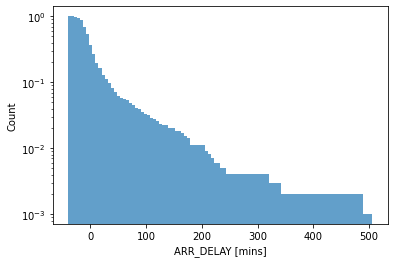

In [24]:
# example: plot BOI-DEN delay distribution
df_sub = df[(df['ORIGIN']=='BOI') & (df['DEST'] == 'DEN')]

plt.hist(df_sub['ARR_DELAY'], bins=100, density=True, histtype="stepfilled", alpha=.7, cumulative=-1)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('ARR_DELAY [mins]')
plt.yscale('log')

/Users/nicolaciocchini/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/nicolaciocchini/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


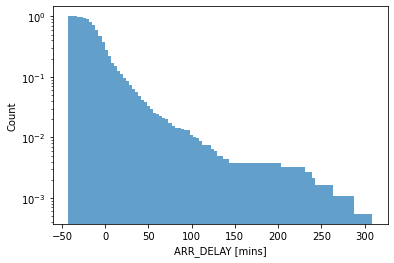

In [25]:
# example 2: plot BOI-SEA delay distribution
df_sub_2 = df[(df['ORIGIN']=='BOI') & (df['DEST'] == 'SEA')]

plt.hist(df_sub_2['ARR_DELAY'], bins=100, density=True, histtype="stepfilled", alpha=.7, cumulative=-1)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('ARR_DELAY [mins]')
plt.yscale('log')